In [159]:
import os
import warnings

# Set environment variables to avoid MKL threading issues
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

In [161]:
# Suppress scikit-learn KMeans warning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from datetime import datetime


In [165]:
# Load datasets with error handling
try:
    C = pd.read_csv("Customers.csv")
    T = pd.read_csv("Transactions.csv")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure Customers.csv and Transactions.csv are in the working directory.")
    exit(1)

In [167]:
# Merge datasets
ct = T.merge(C, on="CustomerID")

In [169]:
# Feature engineering: RFM Analysis
ct["TransactionDate"] = pd.to_datetime(ct["TransactionDate"])
latest_date = ct["TransactionDate"].max()
latest_date

Timestamp('2024-12-28 11:00:00')

In [171]:
# Recency
recency = ct.groupby("CustomerID")["TransactionDate"].max().reset_index()
recency["Recency"] = (latest_date - recency["TransactionDate"]).dt.days
recency.drop(columns=["TransactionDate"], inplace=True)


In [173]:
# Frequency
frequency = ct.groupby("CustomerID")["TransactionID"].count().reset_index()
frequency.rename(columns={"TransactionID": "Frequency"}, inplace=True)

In [175]:
# Monetary Value
monetary = ct.groupby("CustomerID")["TotalValue"].sum().reset_index()
monetary.rename(columns={"TotalValue": "MonetaryValue"}, inplace=True)

In [177]:
# Combine RFM features
customer_features = recency.merge(frequency, on="CustomerID").merge(monetary, on="CustomerID")

In [178]:
# Log-transform Recency and MonetaryValue to reduce skewness
customer_features["Recency"] = np.log1p(customer_features["Recency"])
customer_features["MonetaryValue"] = np.log1p(customer_features["MonetaryValue"])

In [179]:
# Standardize features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(customer_features[["Recency", "Frequency", "MonetaryValue"]])

In [183]:
# Optimize number of clusters using Davies-Bouldin Index
db_scores = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    db_score = davies_bouldin_score(rfm_scaled, labels)
    db_scores.append(db_score)

In [185]:
# Select optimal k (lowest DB score)
optimal_k = k_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 5


In [187]:
# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(rfm_scaled)

In [189]:
# Interpret clusters (analyze centroids)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=["Recency", "Frequency", "MonetaryValue"])
centroid_df["Recency"] = np.expm1(centroid_df["Recency"])  # Reverse log-transform
centroid_df["MonetaryValue"] = np.expm1(centroid_df["MonetaryValue"])
print("Cluster Centroids:\n", centroid_df)

Cluster Centroids:
       Recency  Frequency  MonetaryValue
0    8.878808   8.461538    5713.342355
1   92.497531   3.333333    2269.685742
2   76.518405   6.234375    4252.929971
3    9.109821   4.575000    2796.197306
4  103.988880   1.555556     494.034004


In [191]:
# Save results to CustomerSegments.csv
customer_features[["CustomerID", "Cluster"]].to_csv("CustomerSegments.csv", index=False)
print("Saved clustering results to CustomerSegments.csv")

Saved clustering results to CustomerSegments.csv


In [203]:
customer_features

,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,C0001,4.025352,5,8.118362,2
1,C0002,3.258097,4,7.530341,3
2,C0003,4.836282,4,7.910730,1
3,C0004,1.609438,8,8.585950,0
4,C0005,4.007333,3,7.618369,1
...,...,...,...,...,...
194,C0196,2.639057,4,8.513964,3
195,C0197,0.000000,3,7.565094,3
196,C0198,4.442651,2,6.838223,4
197,C0199,4.158883,4,7.590994,1


Text(0, 0.5, 'Log(Monetary Value)')

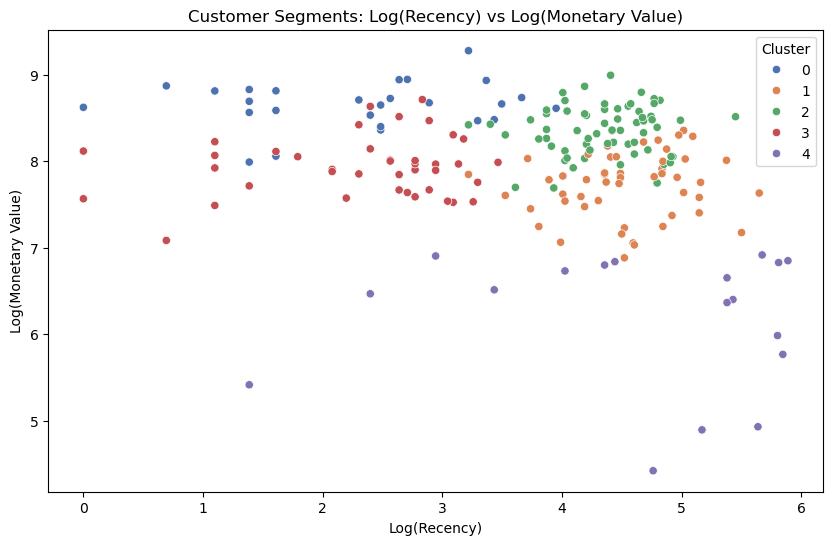

In [201]:
# Visualize clusters (Recency vs MonetaryValue, colored by Cluster)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x="Recency", y="MonetaryValue", hue="Cluster", palette="deep")
plt.title("Customer Segments: Log(Recency) vs Log(Monetary Value)")
plt.xlabel("Log(Recency)")
plt.ylabel("Log(Monetary Value)")


In [199]:
plt.savefig("customer_segments.png")
plt.close()
print("Saved cluster visualization to customer_segments.png")

Saved cluster visualization to customer_segments.png


Text(0, 0.5, 'Davies-Bouldin Index')

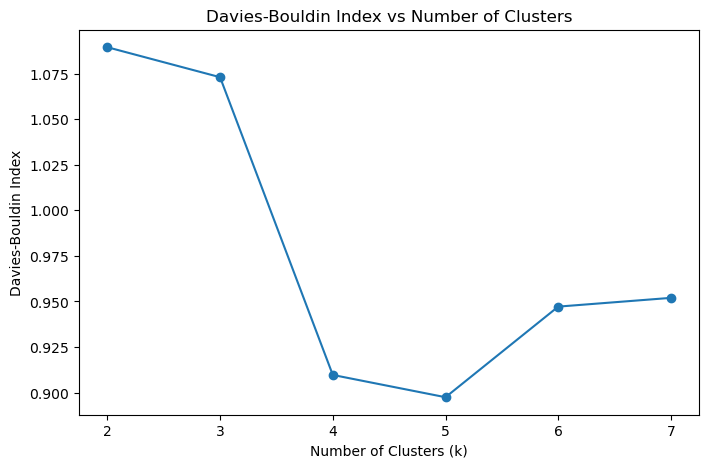

In [197]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, db_scores, marker="o")
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
